In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from math import sin, cos, sqrt, atan2, radians
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

In [2]:
test=pd.read_csv('data/test.csv')
train=pd.read_csv('data/train.csv')
subway=pd.read_csv('data/Subways.csv')
school=pd.read_csv('data/Schools.csv')

In [3]:
train= train.drop_duplicates(train.columns.difference(['key']))

In [4]:
full=pd.concat([train,test],axis=0).reset_index(drop=True)
y=train['transaction_real_price']
full = full.fillna(-999)
full['log_target'] = np.log1p(full['transaction_real_price'])

In [5]:
address_by_law = full['address_by_law'].astype('str')

address_by_law_1 = []
address_by_law_2 = []
address_by_law_3 = []
address_by_law_4 = []

for item in address_by_law:
    address_by_law_1.append(int(item[0:2]))
    address_by_law_2.append(int(item[2:5]))
    address_by_law_3.append(int(item[5:8]))
    address_by_law_4.append(int(item[8:10]))
full['address_by_law_1'] = address_by_law_1
full['address_by_law_2'] = address_by_law_2
full['address_by_law_3'] = address_by_law_3
full['address_by_law_4'] = address_by_law_4
# full=full.drop('address_by_law',axis=1)

In [6]:
new_date = full["transaction_date"].replace({'1~10':'01', '11~20':'10', '21~28':'20', '21~29':'20', '21~30':'20',  '21~31':'20' })
new_date = full["transaction_year_month"].astype('str') + new_date
new_date = pd.to_datetime(new_date, format = '%Y%m%d')
new_date = (new_date - pd.to_datetime("2006-01-01")).dt.days
full['date'] = new_date

In [7]:
full['transaction_year'] = full['transaction_year_month'].astype(str).map(lambda x: int(x[0:4]))
full['transaction_month'] = full['transaction_year_month'].astype(str).map(lambda x: int(x[4:6]))
full=full.drop('transaction_year_month',axis=1)

In [8]:
# full['transaction_date_label_encoding'] = full['transaction_date'].replace({'1~10':0,'11~20':1,'21~31':2,'21~30':2,'21~29':2,'21~28':2})
# label1, unique1=pd.factorize(full['heat_type'])
# full['heat_type_label_encoding']=label1
# label2, unique2=pd.factorize(full['heat_fuel'])
# full['heat_fuel_label_encoding']=label2
# label3, unique3 = pd.factorize(full['front_door_structure'])
# full['front_door_structure_label_encoding']=label3
# # 위에꺼는 label_encoding이라는 거로 feature를 하나 더 만들어준거다.

full['transaction_date'] = full['transaction_date'].replace({'1~10':0,'11~20':1,'21~31':2,'21~30':2,'21~29':2,'21~28':2})
label1, unique1=pd.factorize(full['heat_type'])
full['heat_type']=label1
label2, unique2=pd.factorize(full['heat_fuel'])
full['heat_fuel']=label2
label3, unique3 = pd.factorize(full['front_door_structure'])
full['front_door_structure']=label3
# 이건 그대로 넣은것

In [9]:
# 이건 위에 encoding할때 새로운 col으로 넣고 categorical data column을 지우기 위해 하는 것
# dtype_df = full.dtypes
# str_idx = dtype_df[dtype_df.values == 'object'].index.tolist()
# full = full.drop(str_idx, axis = 1)

In [35]:
sub_cnt=[]
sch_cnt=[]

A=full.drop_duplicates('address_by_law')
A.reset_index(inplace=True)
for i in range(A.shape[0]):
    sub_cnt.append(sum(subway['address_by_law']==A['address_by_law'][i]))
    sch_cnt.append(sum(school['address_by_law']==A['address_by_law'][i]))
A['sub_cnt']=sub_cnt
A['sch_cnt']=sch_cnt
full=pd.merge(full,A[['address_by_law','sub_cnt','sch_cnt']],left_on='address_by_law',right_on='address_by_law',how='left')
# for i in range(full.shape[0]):
#     sub_cnt.append(sum(subway['address_by_law']==full['address_by_law'][i]))
#     sch_cnt.append(sum(school['address_by_law']==full['address_by_law'][i]))

C:\ProgramData\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [37]:
full=full.drop('address_by_law',axis=1)

In [38]:
X=full.drop_duplicates('apartment_id')
X_S=X[X['city']==1]
X_B=X[X['city']==0]
COOR_S=X_S[['apartment_id','latitude','longitude']]
COOR_B=X_B[['apartment_id','latitude','longitude']]
COOR_S.reset_index
COOR_B.reset_index

# Agg_S=AgglomerativeClustering(n_clusters=70, affinity='euclidean', linkage='ward').fit_predict(COOR_S[['latitude','longitude']])
# Agg_B=AgglomerativeClustering(n_clusters=50, affinity='euclidean', linkage='ward').fit_predict(COOR_B[['latitude','longitude']])
kmeans_S = KMeans(n_clusters=70, random_state=0).fit(COOR_S[['latitude','longitude']])
kmeans_B = KMeans(n_clusters=50, random_state=0).fit(COOR_B[['latitude','longitude']])

In [39]:
# COOR_S['cluster_N']=Agg_S
# COOR_B['cluster_N']=Agg_B

COOR_S['cluster_N']=kmeans_S.labels_
COOR_B['cluster_N']=kmeans_B.labels_

C:\ProgramData\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [40]:
COOR_B['cluster_N']+=70
COOR=pd.concat([COOR_S,COOR_B])
full=pd.merge(full,COOR,left_on='apartment_id',right_on='apartment_id',how='left')
full=full.drop(['latitude_y','longitude_y'],axis=1)

C:\ProgramData\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [41]:
val_key = pd.read_csv("data/val_key.csv")
val_key = val_key[val_key['val_key'] > 0].val_key.tolist()

train = full.loc[:train.shape[0] - 1,:]
test = full.loc[train.shape[0]:,:].reset_index(drop = True)

# 아웃라이어 체크 한번 해봄
out_label=[0]*train.shape[0]
for room_id in train.groupby('room_id')['transaction_real_price']:
        limit = room_id[1].mean()-2*sqrt(room_id[1].var())
        for i in range(room_id[1].shape[0]):
            if room_id[1].iloc[i] < limit:
                out_label[room_id[1].index[i]] = 1
train['out_label'] = out_label
val = train[train['key'].isin(val_key)]
train = train.drop(labels = val.index, axis = 0)

print("TRAIN shape : ", train.shape)
print("VAL shape : ", val.shape)
print("TEST shape : ", test.shape)

train.to_csv('data/x_train.csv', encoding = False, index = False)
val.to_csv('data/x_val.csv', encoding = False, index = False)
test.to_csv('data/x_test.csv', encoding = False, index = False)

C:\ProgramData\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


TRAIN shape :  (1551005, 35)
VAL shape :  (3906, 35)
TEST shape :  (3918, 34)


In [43]:
# train[train['transaction_real_price']==max(train[train['out_label']==1]['transaction_real_price'])]['room_id']
# max(train[train['out_label']==1]['transaction_real_price'])
# train[train['room_id']==19253]


,key,apartment_id,city,transaction_date,year_of_completion,exclusive_use_area,floor,latitude_x,longitude_x,total_parking_capacity_in_site,...,address_by_law_2,address_by_law_3,address_by_law_4,date,transaction_year,transaction_month,sub_cnt,sch_cnt,cluster_N,out_label
1049062,1079762,22655,1,2,2011,240.305,3,37.536972,127.009491,1732.0,...,170,131,0,3426,2015,5,2,1,22,0
1061511,1092772,22655,1,2,2011,240.230,3,37.536972,127.009491,1732.0,...,170,131,0,3457,2015,6,2,1,22,0
1086857,1119093,22655,1,1,2011,240.305,3,37.536972,127.009491,1732.0,...,170,131,0,3508,2015,8,2,1,22,0
1157730,1192985,22655,1,1,2011,241.052,2,37.536972,127.009491,1732.0,...,170,131,0,3692,2016,2,2,1,22,0
1158506,1193861,22655,1,0,2011,240.230,-2,37.536972,127.009491,1732.0,...,170,131,0,3683,2016,2,2,1,22,0
1278871,1317951,22655,1,2,2011,240.305,-2,37.536972,127.009491,1732.0,...,170,131,0,3915,2016,9,2,1,22,1
1280781,1320188,22655,1,1,2011,240.230,-1,37.536972,127.009491,1732.0,...,170,131,0,3935,2016,10,2,1,22,0
1285946,1325366,22655,1,1,2011,240.305,1,37.536972,127.009491,1732.0,...,170,131,0,3935,2016,10,2,1,22,0
1299061,1338944,22655,1,2,2011,240.305,-2,37.536972,127.009491,1732.0,...,170,131,0,3945,2016,10,2,1,22,0
1313093,1353494,22655,1,0,2011,240.230,-1,37.536972,127.009491,1732.0,...,170,131,0,3987,2016,12,2,1,22,1


In [52]:
x_train = pd.read_csv('data/x_train.csv')
x_val = pd.read_csv('data/x_val.csv')

x_train = x_train[x_train['transaction_year'] > 2012]
# x_train = x_train[x_train['date'] > 2555]



x_train = x_train[x_train['out_label']==0]
y_train = x_train['log_target']
x_train = x_train.drop(['transaction_real_price', 'log_target','transaction_year','address_by_law_1','out_label'], axis = 1)
features = x_train.columns.tolist()
x_train = x_train.values

x_val = x_val[x_val['out_label']==0]
y_val = x_val['log_target']
x_val = x_val.drop(['transaction_real_price', 'log_target','transaction_year','address_by_law_1','out_label'], axis = 1)

x_val = x_val.values

x_full = np.concatenate((x_train, x_val), axis = 0)
y_full = np.concatenate((y_train, y_val))

print("train shape : ", x_train.shape)
print("val shape : ", x_val.shape)
print("full shape : ", x_full.shape)

train shape :  (834558, 30)
val shape :  (3904, 30)
full shape :  (838462, 30)


In [53]:
model=LGBMRegressor(num_leaves=127,n_estimators=2000,min_child_weight=0.001,learning_rate=0.05)
model.fit(x_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.05, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=2000, n_jobs=-1, num_leaves=127, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [28]:
# model =CatBoostRegressor(iterations=2, depth=2, learning_rate=0.1)
# model.fit(x_train,y_train)
# pred_list=[]
# for n_estimator in list:
#     model=LGBMRegressor(n_estimators=n_estimator)
#     model.fit(x_train,y_train)
#     y_pred = model.predict(x_val)
#     mse = mean_squared_error(np.expm1(y_val), np.expm1(y_pred))
#     pred_list.append(np.sqrt(mse))
# model = XGBRegressor(learning_rate=0.05,max_depth=6,n_estimators=500)
# model.fit(x_train, y_train)
# print(pred_list)
# model.fit(x_train,y_train)

In [54]:
y_pred = model.predict(x_val)
mse = mean_squared_error(np.expm1(y_val), np.expm1(y_pred))
np.sqrt(mse)

55797144.35895541

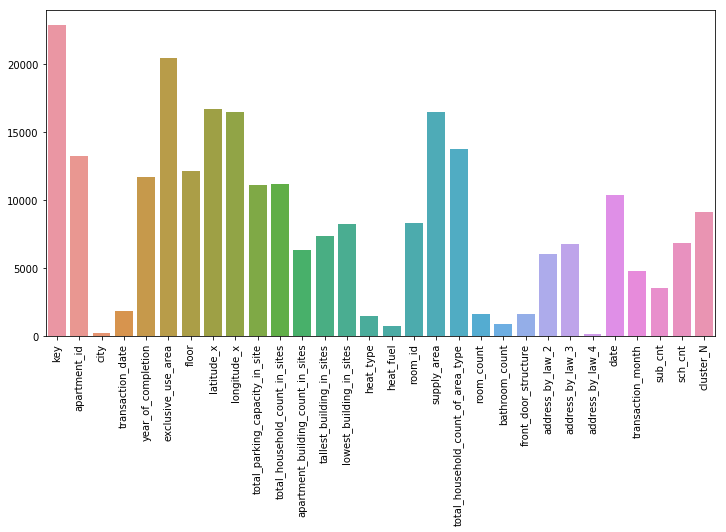

[22840 13262   194  1811 11669 20418 12108 16649 16489 11127 11163  6340
  7339  8220  1436   749  8270 16500 13719  1621   886  1618  6027  6767
   176 10343  4757  3515  6844  9143]


In [55]:
plt.figure(figsize = (12, 6))
sns.barplot(x = features, y = model.feature_importances_)
plt.xticks(rotation = 'vertical')
plt.show()
print(model.feature_importances_)

In [18]:
train_pred = model.predict(x_train)
mse = mean_squared_error(np.expm1(y_train), np.expm1(train_pred))
np.sqrt(mse)

21491650.78895946

In [52]:
model.fit(x_full, y_full)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.05, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=127, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [53]:
x_test = pd.read_csv('data/x_test.csv')
sub = pd.read_csv('data/submission.csv')
TRAIN = pd.read_csv('data/train.csv')
same_instance = pd.read_csv('data/same_instance.csv')
same_instance.columns = ['apartment_id', 'key']

ret = []
for i, row in same_instance.iterrows():
    ret.append(TRAIN[TRAIN['key'] == row['key']]['transaction_real_price'].values[0])
same_instance['transaction_real_price'] = ret

sub['1st'] = pd.merge(left = x_test, right = same_instance[['apartment_id', 'transaction_real_price']], on = 'apartment_id', how = 'left')['transaction_real_price_y']

x_test = x_test.drop(['transaction_real_price', 'log_target'], axis = 1).values
test_pred = np.expm1(model.predict(x_test))
sub['2nd'] = test_pred

sub = sub.fillna(-1)
ret = []
for i, row in sub.iterrows():
    if row['1st'] != -1:
        ret.append(row['1st'])
    else:
        ret.append(row['2nd'])
sub['transaction_real_price'] = ret

sub = sub.drop(['1st', '2nd'], axis = 1)

sub.to_csv("sub.csv", encoding = False, index = False)